# 基于联邦学习的图片分类任务

在这个教程中，我们将使用图像分类任务来介绍在`secretflow`框架下怎样来完成水平联邦学习任务。  
`secretflow`框架提供了一套用户友好的api，可以很方便的将您的keras模型或者pytorch模型应用到联邦学习场景，成为联邦学习模型。  
在接下来的教程中我们将手把手演示，如何将您已有的模型变成`secretflow`下的联邦模型，完成联邦多方建模任务

## 联邦学习

这里的联邦学习特指的是水平场景的联邦学习，也就是样本的联合。这种模式适用于各个参与方业务相同，但触达的客户群不同，这种情况可以联合多方的样本来训练一个性能更好或者泛化性能更好的联合模型。比如在医疗场景，每个医院都有自己独特的病人群，各个地区的医院之间几乎是互不重叠，但是他们对于病历的检查记录（如影像，血检等）又是相同类型的。

<img alt="split_learning_tutorial.png" src="resource/federate_learning.png" width="600">

训练流程:  

1. 各个参与方从服务器下载最新的模型
2. 每个参与方利用本方的本地数据训练模型，将梯度加密（或者将参数加密）上传给服务器，服务器得到各方上传上来的加密梯度（加密参数）在服务端进行安全聚合，用聚合后的梯度更新模型参数。
3. 服务器将更新后的模型返回给各个参与方
4. 各个参与方更新各自的模型，准备下一次训练

## 联邦学习 X SecretFlow

In [1]:
%load_ext autoreload
%autoreload 2

在secretflow环境创造3个实体[Alice，Bob，Charlie]
其中 alice, bob和charlie 是三个PYU，alice和bob角色是client，charlie角色是server  

In [2]:
import secretflow as sf

sf.init(['alice', 'bob', 'charlie'], num_cpus=8, log_to_driver=True)
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

E0307 10:03:27.139174512 1914325 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0307 10:03:27.156145649 1914325 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0307 10:03:27.168126232 1914325 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


In [3]:
ppu = sf.PPU(sf.utils.testing.cluster_def(['alice', 'bob']))

### 准备训练数据

In [4]:
from secretflow.data.ndarray import load
# 加载数据
data_dict = {alice: 'mnist_alice.npz',
               bob: 'mnist_bob.npz'}

fed_npz = load(data_dict, allow_pickle=True)

(PPURuntime pid=1918584) I0307 10:03:30.011243 1918584 external/com_github_brpc_brpc/src/brpc/server.cpp:1046] Server[ppu::link::internal::ReceiverServiceImpl] is serving on port=33045.
(PPURuntime pid=1918584) I0307 10:03:30.011326 1918584 external/com_github_brpc_brpc/src/brpc/server.cpp:1049] Check out http://i85c08157.eu95sqa:33045 in web browser.
(PPURuntime pid=1918585) I0307 10:03:30.021131 1918585 external/com_github_brpc_brpc/src/brpc/server.cpp:1046] Server[ppu::link::internal::ReceiverServiceImpl] is serving on port=56891.
(PPURuntime pid=1918585) I0307 10:03:30.021204 1918585 external/com_github_brpc_brpc/src/brpc/server.cpp:1049] Check out http://i85c08157.eu95sqa:56891 in web browser.
(PPURuntime pid=1918584) I0307 10:03:30.112153 1920424 external/com_github_brpc_brpc/src/brpc/socket.cpp:2202] Checking Socket{id=0 addr=127.0.0.1:56891} (0x563ed479cc40)
(PPURuntime pid=1918584) I0307 10:03:30.112324 1920424 external/com_github_brpc_brpc/src/brpc/socket.cpp:2262] Revived So

(PPURuntime pid=1918584) [2022-03-07 10:03:30.011] [info] [context.cc:58] connecting to mesh, id=root, self=0
(PPURuntime pid=1918584) [2022-03-07 10:03:30.029] [info] [context.cc:83] try_connect to rank 1 not succeed, sleep_for 1000ms and retry.
(PPURuntime pid=1918585) [2022-03-07 10:03:30.021] [info] [context.cc:58] connecting to mesh, id=root, self=1
(PPURuntime pid=1918584) [2022-03-07 10:03:31.030] [info] [context.cc:111] connected to mesh, id=root, self=0
(PPURuntime pid=1918585) [2022-03-07 10:03:31.029] [info] [context.cc:111] connected to mesh, id=root, self=1


(_run pid=1918583) 2022-03-07 10:03:31,302,302 DEBUG [connectionpool.py:_new_conn:1001] Starting new HTTPS connection (1): federal.oss-cn-hangzhou.aliyuncs.com:443
(_run pid=1918583) 2022-03-07 10:03:31,376,376 DEBUG [connectionpool.py:_make_request:456] https://federal.oss-cn-hangzhou.aliyuncs.com:443 "GET /dataset/public/mnist/mnist_alice.npz HTTP/1.1" 200 63520506
(_run pid=1918583) 2022-03-07 10:03:35,361,361 DEBUG [connectionpool.py:_new_conn:1001] Starting new HTTPS connection (1): federal.oss-cn-hangzhou.aliyuncs.com:443
(_run pid=1918583) 2022-03-07 10:03:35,460,460 DEBUG [connectionpool.py:_make_request:456] https://federal.oss-cn-hangzhou.aliyuncs.com:443 "GET /dataset/public/mnist/mnist_bob.npz HTTP/1.1" 200 127040506


fed_npz是一个字典，从中拿出image和label就是后面联邦训练需要的FedNdarray

In [5]:
image = fed_npz['image']
label = fed_npz['label']

我们来看一下获得到的FedNdarray数据，FedNdarray是一个构建在多方概念上的虚拟的Ndarray，目的是保护数据隐私。  
底层数据存储在各个参与方，对于FedNdarray的操作，实际上只是各个参与方对自己的local数据做操作。server端或者其他client不会接触到原始的数据。  
这里为了方便演示，我们手动把数据下载到driver端
**这个数据在后面的单方模型对比使用**

In [6]:
import requests
import io
import numpy as np

dataset_dict = {}
for device, url in data_dict.items():
    response = requests.get(url)
    response.raise_for_status()
    dataset_dict[device] = np.load(io.BytesIO(response.content))

In [7]:
alice_data,alice_label = dataset_dict[alice]["image"],dataset_dict[alice]["label"]
bob_data, bob_label = dataset_dict[bob]["image"], dataset_dict[bob]["label"]

让我们从数据集中抓取一些样本，通过可视化的方法来看看，在alice和bob两方的数据是什么样？

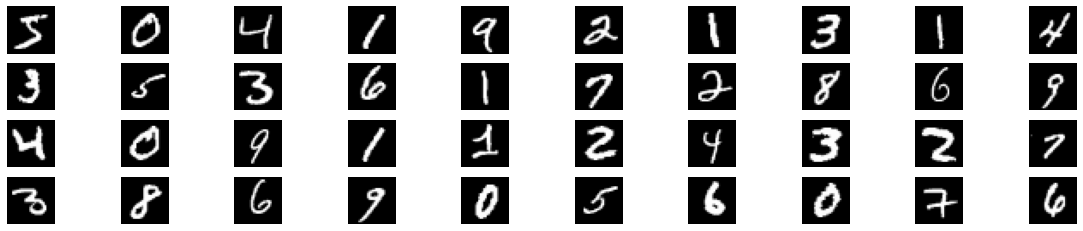

In [8]:
from matplotlib import pyplot as plt

figure = plt.figure(figsize=(20, 4))
j = 0

for example in alice_data[:40]:
  plt.subplot(4, 10, j+1)
  plt.imshow(example, cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

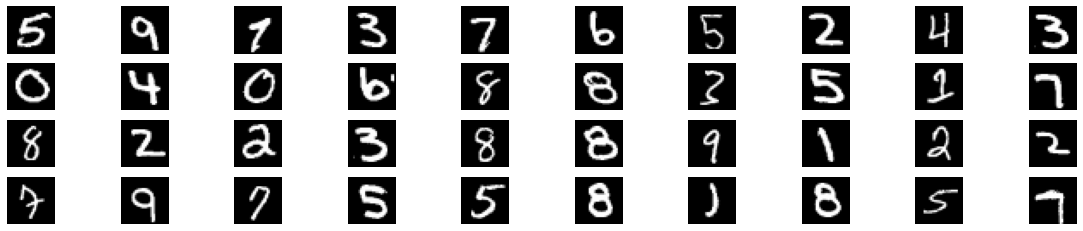

In [9]:
figure = plt.figure(figsize=(20, 4))
j = 0
for example in bob_data[:40]:
  plt.subplot(4, 10, j+1)
  plt.imshow(example, cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

从上面两个例子可以看出，alice和bob的数据类型和任务都是一致的，但是由于触达的用户群不同，所以样本会有差别。

让我们再次拿出之前已经得到的FedNdarray，并对他们做训练接和测试集的拆分来交给后面的训练任务

In [10]:
from secretflow.data.split import train_test_split
random_seed = 1234
train_image, test_image = train_test_split(data=image, train_size=0.8, random_state=random_seed)
train_label, test_label = train_test_split(data=label, train_size=0.8, random_state=random_seed)

### 定义模型

In [11]:
def create_conv_model(input_shape, num_classes, name='model'):
    def create_model():
        from tensorflow import keras
        from tensorflow.keras import layers
        # Create model
        model = keras.Sequential(
            [
                keras.Input(shape=input_shape),
                layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Flatten(),
                layers.Dropout(0.5),
                layers.Dense(num_classes, activation="softmax"),
            ]
        )
        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=["accuracy"])
        return model

    return create_model


### 联邦训练

1. 导入训练所需的包

In [12]:
from secretflow.security.aggregation import PlainAggregator, DeviceAggregator, SecureAggregator
from secretflow.model.fl_model import FLTFModel

2022-03-07 10:04:15.076672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtoolset-10/root/usr/lib64/dyninst:/opt/rh/devtoolset-10/root/usr/lib/dyninst:/opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib


2. 定义模型

In [13]:
num_classes = 10
input_shape = (28, 28, 1)
model = create_conv_model(input_shape, num_classes)

3. 定义参与训练的device_list，即之前准备好的各个参与方的PYU

In [14]:
device_list = [alice, bob]

4. 定义聚合函数  
 隐语提供了多种聚合方案，`PlainAggregator`对应明文聚合，`SecureAggregator`和`PPUAggregator`可用于安全聚合，更多安全聚合方案可以参考[安全聚合](./Secure_aggregation.ipynb)。

In [15]:
plain_aggregator = PlainAggregator(charlie)
secure_aggregator = SecureAggregator(charlie, [alice, bob])
ppu_aggregator = DeviceAggregator(ppu)


5. 定义联邦模型

In [16]:
fed_model = FLTFModel(
            device_list=device_list, model=model, aggregator=secure_aggregator)

(_run pid=1918583) 2022-03-07 10:04:26.641431: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtoolset-10/root/usr/lib64/dyninst:/opt/rh/devtoolset-10/root/usr/lib/dyninst:/opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib
(_run pid=1918595) 2022-03-07 10:04:26.945611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtoolset-10/root/usr/lib64/dyninst:/opt/rh/devtoolset-10/root/usr/lib/dyninst:/opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib
(_

6. 跑起来

In [17]:
fed_model.fit(train_image, train_label, validation_data=(test_image,test_label), epochs=10, batch_size=128, aggregate_freq=1)

32/32 [==============================] - 0s 5ms/step - loss: 0.1286 - accuracy: 0.9610
valid_eval=[0.1301192  0.96087495]
32/32 [==============================] - 0s 4ms/step - loss: 0.0879 - accuracy: 0.9730
valid_eval=[0.0898173 0.9731249]
32/32 [==============================] - 0s 4ms/step - loss: 0.0726 - accuracy: 0.9783
valid_eval=[0.07248015 0.97768745]
32/32 [==============================] - 0s 4ms/step - loss: 0.0606 - accuracy: 0.9825
valid_eval=[0.06052585 0.98193745]
32/32 [==============================] - 0s 5ms/step - loss: 0.0528 - accuracy: 0.9847
valid_eval=[0.05347985 0.98412495]
61/63 [============================>.] - ETA: 0s - loss: 0.0548 - accuracy: 0.9825
valid_eval=[0.05178695 0.98431245]
63/63 [==============================] - 0s 4ms/step - loss: 0.0550 - accuracy: 0.9824
(_run pid=1918588) 
32/32 [==============================] - 0s 4ms/step - loss: 0.0462 - accuracy: 0.9847
valid_eval=[0.0477842  0.98493745]
32/32 [==============================] - 0s 5

In [18]:
global_metric = fed_model.evaluate(test_image, test_label, batch_size=128)
print(global_metric)

32/32 [==============================] - 0s 4ms/step - loss: 0.0420 - accuracy: 0.9862
[0.04222295 0.98649995]
63/63 [==============================] - 0s 4ms/step - loss: 0.0424 - accuracy: 0.9868


### 对比单方模型

#### 模型
模型结构和上面fl的模型保持一致
#### 数据
数据同样使用mnist数据集，单方模型这里我们只是用了切分后的alice方数据共20000个样本

In [19]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.model_selection import train_test_split

def create_model():

    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=["accuracy"])
    return model

single_model = create_model()

2022-03-07 10:07:27.101911: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtoolset-10/root/usr/lib64/dyninst:/opt/rh/devtoolset-10/root/usr/lib/dyninst:/opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib
2022-03-07 10:07:27.101950: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [20]:
from sklearn.model_selection import train_test_split
random_seed = 1234
X_train, X_test, y_train, y_test = train_test_split(alice_data, alice_label, test_size=0.33, random_state=random_seed)

In [21]:
single_model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=128,epochs=10)

Epoch 1/10
105/105 [==============================] - 2s 15ms/step - loss: 0.8655 - accuracy: 0.7389 - val_loss: 0.2530 - val_accuracy: 0.9265
Epoch 2/10
105/105 [==============================] - 1s 13ms/step - loss: 0.2373 - accuracy: 0.9259 - val_loss: 0.1589 - val_accuracy: 0.9529
Epoch 3/10
105/105 [==============================] - 1s 14ms/step - loss: 0.1659 - accuracy: 0.9485 - val_loss: 0.1242 - val_accuracy: 0.9614
Epoch 4/10
105/105 [==============================] - 1s 14ms/step - loss: 0.1341 - accuracy: 0.9589 - val_loss: 0.1050 - val_accuracy: 0.9676
Epoch 5/10
105/105 [==============================] - 1s 13ms/step - loss: 0.1124 - accuracy: 0.9645 - val_loss: 0.0932 - val_accuracy: 0.9688
Epoch 6/10
105/105 [==============================] - 1s 13ms/step - loss: 0.0990 - accuracy: 0.9689 - val_loss: 0.0862 - val_accuracy: 0.9733
Epoch 7/10
105/105 [==============================] - 1s 14ms/step - loss: 0.0880 - accuracy: 0.9730 - val_loss: 0.0823 - val_accuracy: 0.9738

上面两个实验模拟了一个典型的水平联邦场景的训练问题，
* alice和bob拥有类型的图片
* 每一方只有样本的一部分数据，但是双方的训练目的是一致的  
如果alice只用自己的一方数据来训练模型，能够得到一个精确度0.978的模型，但是如果联合bob的数据之后，可以获得一个精确度接近0.99的模型，而且多方数据联合训练的模型的泛化性能也会更好

## 总结
* 本篇我们介绍了什么是联邦学习，以及如何在secretflow框架下进行水平联邦学习  
* 从实验数据可以看出，水平联邦通过扩充样本量，联合多方训练可以提升模型效果
* 本文档使用了安全聚合（SecureAggregator）来做演示，secretflow提供了多种聚合方案，您可以在[安全聚合](./Secure_aggregation.ipynb)了解更多信息。
* 下一步，你可能想尝试不同的数据集，您需要先将数据集进行垂直切分，然后按照本教程的流程进行


